In [1]:
pip install git+https://github.com/astropy/astroquery.git

  Cloning https://github.com/astropy/astroquery.git to c:\users\lenovo\appdata\local\temp\pip-req-build-7ynxsunj
  Resolved https://github.com/astropy/astroquery.git to commit 1d862346daccd38da2daf78d31595ee087b3321f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   -------- ------------------------------- 1.3/6.4 MB 8.4 MB/s eta 0:00:01
   ---------------------- ----------------- 3.7/6.4 MB 9.9 MB/s eta 0:00:01
   ------------------------------------- -- 6.0/6.4 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 6.4/6.4 MB 9.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----------

  Running command git clone --filter=blob:none --quiet https://github.com/astropy/astroquery.git 'C:\Users\Lenovo\AppData\Local\Temp\pip-req-build-7ynxsunj'
  Running command git submodule update --init --recursive -q

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
from astroquery.mast import Observations

# Search for Hubble observations of Jupiter with spectroscopic data
obs_table = Observations.query_criteria(
    target_name="JUPITER", 
    dataproduct_type="spectrum", 
    instrument_name="WFC3/UVIS"
)
# Download the calibrated science products
Observations.download_products(obs_table[0])

IndexError: index 0 out of range for table with length 0

In [2]:
pip install astropy matplotlib requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [92]:
import os
import numpy as np
from astroquery.mast import Observations
from astropy.table import vstack

TARGETS = ["VENUS"] 
OUTPUT_DIR = r"E:\DataFecked Hackathon"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_planetary_uv_spectra(target_name):
    print(f"\n🔭 STARTING MULTI-OBS SEARCH FOR: {target_name}")
    
    obs_table = Observations.query_criteria(
        target_name="VENUS*",
        instrument_name="STIS",
        dataproduct_type="spectrum",
        filters=["G140L", "E140M", "E140H"] # Explicitly ask for different spectral slices
    )
    
    if len(obs_table) == 0: return False
    
    # Instead of np.unique(obsid), let's get the best file per FILTER
    unique_filters = np.unique(obs_table['filters'])
    all_candidates = []
    
    for filt in unique_filters:
        filt_data = obs_table[obs_table['filters'] == filt]
        filt_data.sort("t_exptime")
        best_for_filt = filt_data[-1] # Get the longest exposure for EACH filter
    
        products = Observations.get_product_list(best_for_filt)
        filtered = Observations.filter_products(products, productSubGroupDescription="X1D")
        if len(filtered) > 0:
            all_candidates.append(filtered[0])

    if all_candidates:
        final_download_list = vstack(all_candidates)
        print(f"⬇️ Downloading {len(final_download_list)} unique spectral slices...")
        Observations.download_products(final_download_list, download_dir=OUTPUT_DIR)
        return True
    return False

for target in TARGETS:
    fetch_planetary_uv_spectra(target)


🔭 STARTING MULTI-OBS SEARCH FOR: VENUS
⬇️ Downloading 1 unique spectral slices...
INFO: Found cached file E:\DataFecked Hackathon\mastDownload\HST\o6bbb1020\o6bbb1020_x1d.fits with size 2105280 = 2105280. [astroquery.query]


In [180]:
import os
import numpy as np
from astroquery.mast import Observations

# --- CONFIGURATION ---
TARGETS = ["VENUS"] 
OUTPUT_DIR = r"E:\DataFecked Hackathon"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_planetary_uv_spectra(target_name):
    print(f"\n🚀 TARGET SEARCH: {target_name}")
    
    # 1. Query with instrument/filter focus
    # We broaden to target* but specifically look for NUV-capable instruments
    obs_table = Observations.query_criteria(
        target_name=target_name + "*",
        dataproduct_type="spectrum",
        obs_collection="HST",
        instrument_name="STIS*" # STIS is the king of the 2000-3000A range
    )
    
    if len(obs_table) == 0:
         print(f"❌ No STIS data for {target_name}. Trying all HST...")
         obs_table = Observations.query_criteria(target_name=target_name + "*", dataproduct_type="spectrum", obs_collection="HST")

    if len(obs_table) == 0: return False
        
    # 2. SELECTION LOGIC: We need one FUV and one NUV
    # Filters starting with 'E230' or 'G230' are NUV (Sulfur/Ozone)
    # Filters starting with 'E140' or 'G140' are FUV (Oxygen/Hydrogen)
    
    nuv_obs = [row for row in obs_table if "230" in str(row['filters'])]
    fuv_obs = [row for row in obs_table if "140" in str(row['filters'])]
    
    print(f"📊 Market Report: Found {len(nuv_obs)} NUV candidates and {len(fuv_obs)} FUV candidates.")

    # Grab the best from each category
    final_selection = []
    if nuv_obs: final_selection.append(nuv_obs[-1]) # Best NUV
    if fuv_obs: final_selection.append(fuv_obs[-1]) # Best FUV
    
    # If we found nothing specific, fall back to the original top 3
    if not final_selection:
        obs_table.sort("t_exptime")
        final_selection = obs_table[-3:]

    for obs in final_selection:
        print(f"🔍 Downloading: {obs['obsid']} | Filter: {obs['filters']} | Range: {'NUV (Sulfur)' if '230' in str(obs['filters']) else 'FUV (Oxygen)'}")
        
        data_products = Observations.get_product_list(obs)
        
        # 3. Preference Logic: X1D is usually the best for STIS
        for p_type in ["X1D", "SX1"]:
            filtered = Observations.filter_products(data_products, productSubGroupDescription=p_type)
            if len(filtered) > 0:
                Observations.download_products(filtered, download_dir=OUTPUT_DIR)
                print(f"   🎉 {target_name} {p_type} secured.")
                break
    
    return True

for target in TARGETS:
    fetch_planetary_uv_spectra(target)


🚀 TARGET SEARCH: VENUS
📊 Market Report: Found 6 NUV candidates and 13 FUV candidates.
🔍 Downloading: 24963308 | Filter: G230LB | Range: NUV (Sulfur)
INFO: Found cached file E:\DataFecked Hackathon\mastDownload\HST\obo0c1010\obo0c1010_x1d.fits with size 80640 = 80640. [astroquery.query]
   🎉 VENUS X1D secured.
🔍 Downloading: 199092647 | Filter: E140H | Range: FUV (Oxygen)
INFO: Found cached file E:\DataFecked Hackathon\mastDownload\HST\o6bbb1020\o6bbb1020_x1d.fits with size 2105280 = 2105280. [astroquery.query]
   🎉 VENUS X1D secured.


In [4]:
import os
import pandas as pd
from astroquery.mast import Observations

# --- CONFIGURATION ---
# We are hunting for Venus and Mars (Missing) and better Neptune IR
TARGETS = ["MARS", "VENUS", "NEPTUNE"] 
OUTPUT_DIR = r"E:\DataFecked Hackathon\IR_Search_Results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_planetary_ir_spectra(target_name):
    print(f"\n🔦 IR HUNT: {target_name}")
    
    # We look for Mid-IR (Spitzer) and Near-IR (HST WFC3/NICMOS)
    # JWST is also an option for Neptune
    obs_table = Observations.query_criteria(
        target_name=target_name + "*",
        dataproduct_type=["spectrum", "cube"],
        instrument_name=["IRS*", "WFC3/IR", "NIC*", "MIRI*", "NIRSPEC*"]
    )
    
    if len(obs_table) == 0:
        print(f"⚠️ No specific IR instruments found for {target_name}. Checking all archives...")
        obs_table = Observations.query_criteria(target_name=target_name + "*", dataproduct_type="spectrum")

    if len(obs_table) == 0: 
        print(f"❌ No IR data found for {target_name}.")
        return False

    # Filter for the most recent or highest quality observations
    obs_table.sort("t_min", reverse=True) 
    
    # Select top 3 candidates to ensure we get something usable
    selection = obs_table[:3]

    for obs in selection:
        print(f"🔍 Found: {obs['obsid']} | Instrument: {obs['instrument_name']} | Filter: {obs['filters']}")
        
        products = Observations.get_product_list(obs)
        # We want the 1D extracted spectra (X1D for HST/JWST, CAL for Spitzer)
        filtered = Observations.filter_products(products, 
                                              productSubGroupDescription=["X1D", "S1D", "CAL", "SPEC"])
        
        if len(filtered) > 0:
            Observations.download_products(filtered[:1], download_dir=OUTPUT_DIR)
            print(f"✅ {target_name} IR data downloaded.")
            
    return True

for target in TARGETS:
    fetch_planetary_ir_spectra(target)


🔦 IR HUNT: MARS


Skipping NIC*... [astroquery.mast.discovery_portal]
Skipping NIRSPEC*... [astroquery.mast.discovery_portal]


🔍 Found: 24800974 | Instrument: WFC3/IR | Filter: G141
🔍 Found: 24800966 | Instrument: WFC3/IR | Filter: G141
🔍 Found: 24800970 | Instrument: WFC3/IR | Filter: G141

🔦 IR HUNT: VENUS


⚠️ No specific IR instruments found for VENUS. Checking all archives...
🔍 Found: 24528884 | Instrument: STIS/FUV-MAMA | Filter: E140H
🔍 Found: 24528880 | Instrument: STIS/FUV-MAMA | Filter: E140H
🔍 Found: 24967265 | Instrument: STIS/FUV-MAMA | Filter: E140H

🔦 IR HUNT: NEPTUNE
🔍 Found: 1718386 | Instrument: IRS | Filter: IRS-LL
🔍 Found: 1718386 | Instrument: IRS | Filter: IRS-LL
🔍 Found: 1718386 | Instrument: IRS | Filter: IRS-LL


In [85]:
from astropy.io import fits
import numpy as np
import pandas as pd

# Path to your 3D cube
file_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Jupiter - mastDownload\IR data\jw01248001001_03105_00001_mirifushort_s3d.fits"

with fits.open(file_path) as hdul:
    data = hdul['SCI'].data    # The 3D image stack
    header = hdul['SCI'].header
    
    # Fast Wavelength calculation (Standard for MIRI S3D)
    # Uses CRVAL3 (start) and CDELT3 (step) if available, 
    # or falls back to standard MIRI Short Channel 1A range
    n_waves = header['NAXIS3']
    if 'CDELT3' in header:
        wavelengths = header['CRVAL3'] + np.arange(n_waves) * header['CDELT3']
    else:
        # Emergency fallback for MIRI Short Channel 1
        wavelengths = np.linspace(4.9, 5.8, n_waves) 

# 1. Average all spatial pixels to get 1D signal
# nanmean handles the "empty" black space around Jupiter
spectrum_1d = np.nanmean(data, axis=(1, 2))

# 2. Pack into DataFrame
jupiter_df = pd.DataFrame({
    'wavelength_um': wavelengths,
    'flux_mjy_sr': spectrum_1d
}).dropna()

# 3. Save as PKL
jupiter_df.to_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Jupiter - mastDownload\IR data\Cleaned_Jupiter_IR.pkl")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11148\1407068256.py:24: RuntimeWarning: Mean of empty slice
  spectrum_1d = np.nanmean(data, axis=(1, 2))


In [83]:
from astropy.io import fits
import pandas as pd

# This is the file you uploaded
x1d_file = "E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Jupiter - mastDownload\IR data\jw01248001001_03105_00001_mirifushort_s3d.fits"

with fits.open(x1d_file) as hdul:
    # Extension 1 (EXTRACT1D) contains the table data
    data = hdul['EXTRACT1D'].data
    
    # Extract the key columns
    wavelength = data['WAVELENGTH'] # in microns
    flux = data['FLUX']             # in Janskys (usually)
    error = data['ERROR']           # uncertainty
    
# Create the Jupiter Master DataFrame
jupiter_master = pd.DataFrame({
    'wavelength_um': wavelength,
    'flux_jy': flux,
    'uncertainty': error
})

# Clean: Remove any rows with NaN or zero flux
jupiter_master = jupiter_master[jupiter_master['flux_jy'] > 0].dropna()

# Save to PKL to match your Venus workflow
jupiter_master.to_pickle('JUPITER_MASTER_SPECTRUM.pkl')

print("Jupiter Master Spectrum ready!")
print(f"Wavelength range: {jupiter_master['wavelength_um'].min():.2f} to {jupiter_master['wavelength_um'].max():.2f} um")

KeyError: "Extension 'EXTRACT1D' not found."

In [82]:
import pandas as pd
df = pd.read_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Venus - mastDownload\IR data\Cleaned_Venus_IR.pkl")
df

,wavelength_um,radiance
0,0.250000,17488.0
1,0.257895,11588.0
2,0.265789,31428.0
3,0.273684,26948.0
4,0.281579,63043.0
...,...,...
586,4.972158,52028.0
587,4.979118,37245.0
588,4.986079,5180.0
589,4.993039,41789.0


In [81]:
import pandas as pd
import glob
import os
import io

# 1. Setup paths
input_folder = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Mars_IR"
output_file = os.path.join(input_folder, "Mars_Combined_Spectrum.pkl")

# 2. List the 4 files you extracted
files = [
    os.path.join(input_folder, "SPITZER_S1_9004032_0003_0000_9_spect.tbl"),
    os.path.join(input_folder, "SPITZER_S1_9004032_0003_0001_9_spect.tbl"),
    os.path.join(input_folder, "SPITZER_S3_9004032_0004_0000_9_spect.tbl"),
    os.path.join(input_folder, "SPITZER_S3_9004032_0005_0000_9_spect.tbl")
]

all_data = []

print(f"🔄 Starting merge of {len(files)} files...")

for file in files:
    if not os.path.exists(file):
        print(f"  ⚠️ Skipping missing file: {os.path.basename(file)}")
        continue
        
    try:
        # STRIP HEADERS MANUALLY: 
        # We skip any line that starts with '\' (metadata) or '|' (column labels)
        with open(file, 'r') as f:
            clean_lines = [line for line in f if not (line.startswith('\\') or line.startswith('|')) and line.strip()]
        
        # Turn the text lines back into a "file" for Pandas
        clean_content = "".join(clean_lines)
        
        # Read the numeric columns
        # Spitzer tune.tbl columns are: 0:Order, 1:Wavelength, 2:Flux, 3:Uncertainty, 4:Status
        df = pd.read_csv(io.StringIO(clean_content), sep='\s+', header=None, engine='python')
        
        # Keep only first 5 columns and rename
        df = df.iloc[:, :5]
        df.columns = ['order', 'wavelength', 'flux', 'uncertainty', 'status']
        
        # Add module name (e.g., S0, S1, S3) from filename
        module_name = os.path.basename(file).split('_')[1]
        df['module'] = module_name
        
        all_data.append(df)
        print(f"  ✅ Successfully merged: {os.path.basename(file)} (Module {module_name})")
        
    except Exception as e:
        print(f"  ❌ Error processing {os.path.basename(file)}: {e}")

# 3. Combine and Save
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    
    # Sort by wavelength so the spectrum goes from 5um up to 37um smoothly
    final_df = final_df.sort_values(by='wavelength').reset_index(drop=True)
    
    # Save as Pickle
    final_df.to_pickle(output_file)
    
    print("\n" + "="*30)
    print(f"🚀 MISSION ACCOMPLISHED!")
    print(f"File Saved: {output_file}")
    print(f"Total Rows: {len(final_df)}")
    print(f"Wavelength Range: {final_df['wavelength'].min():.2f} to {final_df['wavelength'].max():.2f} µm")
    print("="*30)
else:
    print("\n❌ No data was combined. Check the file paths again.")

🔄 Starting merge of 4 files...
  ⚠️ Skipping missing file: SPITZER_S1_9004032_0003_0000_9_spect.tbl
  ⚠️ Skipping missing file: SPITZER_S1_9004032_0003_0001_9_spect.tbl
  ⚠️ Skipping missing file: SPITZER_S3_9004032_0004_0000_9_spect.tbl
  ⚠️ Skipping missing file: SPITZER_S3_9004032_0005_0000_9_spect.tbl

❌ No data was combined. Check the file paths again.


In [61]:
import pandas as pd
import numpy as np

# 1. Load your master file
df = pd.read_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Mars_IR\Mars_Combined_Spectrum.pkl")

# 2. Remove "Status" errors
# Spitzer marks bad data with status codes > 0. Let's keep only the 'Good' data.
df_clean = df[df['status'] == 0].copy()

# 3. Handle Overlaps & Outliers (The "Spike" Filter)
# Sometimes cosmic rays create crazy flux values. 
# We'll remove anything more than 5 standard deviations from the mean flux.
mean_flux = df_clean['flux'].mean()
std_flux = df_clean['flux'].std()
df_clean = df_clean[df_clean['flux'] < (mean_flux + 5 * std_flux)]

# 4. Smoothing (Optional but recommended for Hackathons)
# This reduces the "fuzziness" of the line so you can see the atmosphere better.
df_clean['flux_smooth'] = df_clean['flux'].rolling(window=5, center=True).mean()

# 5. Save the Cleaned Version
df_clean.to_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Mars_IR\Mars_CLEANED_Spectrum.pkl")
print("✨ Cleaning Complete!")
print(f"Kept {len(df_clean)} out of {len(df)} points.")

✨ Cleaning Complete!
Kept 3283 out of 4620 points.


In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both versions
df_raw = pd.read_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Neptune_IR\Neptune_Combined_Spectrum.pkl")
df_clean = pd.read_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Neptune_IR\Neptune_CLEANED_Spectrum.pkl")

plt.figure(figsize=(12, 6))

# Plot Raw data in the background (faded)
plt.scatter(df_raw['wavelength'], df_raw['flux'], color='gray', alpha=0.3, s=5, label='Raw Data (with Noise)')

# Plot Cleaned data on top
plt.scatter(df_clean['wavelength'], df_clean['flux'], color='red', s=5, label='Cleaned Data (Status=0)')

plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux (Jy)")
plt.title("Neptune Data Quality Check: Raw vs. Cleaned")
plt.legend()
plt.ylim(0, df_clean['flux'].max() * 1.2) # Zoom in to the real data range
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Data Fecked Hackathon\\Spectral Data Cleaning and Sorting\\Whole IR data\\Neptune_IR\\Neptune_Combined_Spectrum.pkl'

In [63]:
df = pd.read_pickle(r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Mars_IR\Mars_CLEANED_Spectrum.pkl")
df

,order,wavelength,flux,uncertainty,status,module,flux_smooth
2,20,9.89390,0.060613,0.012594,0,S1,NaN
4,20,9.90151,0.050957,0.009159,0,S1,NaN
5,20,9.90151,0.061471,0.010349,0,S1,0.043411
6,20,9.90913,0.017309,0.005836,0,S1,0.034869
7,20,9.90913,0.026705,0.006194,0,S1,0.025205
...,...,...,...,...,...,...,...
4593,11,36.73583,0.211976,0.058339,0,S3,0.157268
4594,11,36.76645,0.141953,0.065806,0,S3,0.209120
4595,11,36.76645,0.149495,0.058830,0,S3,0.243519
4596,11,36.79710,0.343441,0.049533,0,S3,NaN


In [64]:
# Keep only the essential science columns
df_final = df_clean[['wavelength', 'flux', 'uncertainty']].copy()
df_final.head()

,wavelength,flux,uncertainty
2,9.89390,0.060613,0.012594
4,9.90151,0.050957,0.009159
5,9.90151,0.061471,0.010349
6,9.90913,0.017309,0.005836
7,9.90913,0.026705,0.006194


In [66]:
final_output_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Whole IR data\Mars_IR\Mars_CLEANED_Spectrum.pkl"
df_final.to_pickle(final_output_path)

In [185]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle
import os

# --- UNIVERSAL SPECTRAL FEATURE DICTIONARY ---
PLANETARY_SIGNATURES = {
    "EMISSION": {
        "H I (Lyman-alpha)": 1215.67,
        "O I (Oxygen)": 1304.86,
        "O I (Forbidden)": 1356.0,
        "N I (Nitrogen)": 1493.0,
        "C I (Carbon)": 1657.0,
        "Mg I (Magnesium)": 2852.0,
    },
    "ABSORPTION": {
        "CH4 (Methane)": (1400, 1600),
        "C2H2 (Acetylene)": (1700, 1900),
        "O3 (Ozone)": (2400, 2600),
        "SO2 (Sulfur Dioxide)": (2000, 2300)
    }
}

PLANETARY_SIGNATURES["EMISSION"].update({
    "N I (Nitrogen)": 1200.0,       # Found in Venus dayglow
    "C II (Carbon Ion)": 1335.7,    # Right at the edge of your data!
    "O I (Triplet)": 1302.0,        # Oxygen sub-component
})

PLANETARY_SIGNATURES["ABSORPTION"].update({
    "CO (Fourth Positive)": (1400, 1700), # Broad electronic transitions in CO
    "SO2 (Strong)": (2000, 2200),         # The deepest part of the SO2 forest
    "SO2 (Broad)": (2200, 3000)           # The long tail of sulfur absorption
})

def identify_elements(wave, flux, planet_type="GAS_GIANT", threshold=1.2):
    print(f"\n--- 🧪 CHEMICAL AUDIT ({planet_type}) ---")
    w_min, w_max = np.min(wave), np.max(wave)
    print(f"DEBUG: Analyzing slice {w_min:.1f} - {w_max:.1f} Å")

    # --- 1. SCAN FOR EMISSION SPIKES (Works for ALL planets) ---
    for name, line_wave in PLANETARY_SIGNATURES["EMISSION"].items():
        if w_min < line_wave < w_max:
            # Find the closest pixel to the theoretical line
            idx = (np.abs(wave - line_wave)).argmin()
            
            # Look at a 20-pixel local neighborhood to see if it's a "spike"
            local_window = flux[max(0, idx-10):min(len(flux), idx+10)]
            local_avg = np.mean(local_window)
            
            if flux[idx] > local_avg * threshold:
                print(f"✨ DETECTED EMISSION: {name} at {wave[idx]:.1f} Å")
            else:
                print(f"ℹ️ {name} emission line in range, but no spike detected.")

    # --- 2. SCAN FOR ABSORPTION BANDS (Giants only) ---
    if planet_type in ["GAS_GIANT", "ICE_GIANT"]:
        for name, (low, high) in PLANETARY_SIGNATURES["ABSORPTION"].items():
            intersect_min = max(w_min, low)
            intersect_max = min(w_max, high)
            
            if (intersect_max - intersect_min) > 50:
                mask = (wave >= intersect_min) & (wave <= intersect_max)
                avg_zone = np.mean(flux[mask])
                
                if avg_zone < np.mean(flux) * (1/threshold):
                    print(f"☁️ DETECTED ABSORPTION: {name} (Visible: {intersect_min:.0f}-{intersect_max:.0f} Å)")
                else:
                    print(f"ℹ️ {name} absorption range visible, but signal strength too high.")
                
def process_universal_raw(file_paths, planet_name, planet_type, threshold=1.2):
    """Stitches all file data together so the Master PKL isn't just the last file."""
    print(f"\n--- 🛰️ PROCESSING: {planet_name.upper()} ---")
    
    all_waves = []
    all_fluxes = []
    
    for f_path in file_paths:
        with fits.open(f_path) as hdul:
            data = hdul[1].data
            w_raw = data['WAVELENGTH'].flatten()
            f_raw = data['FLUX'].flatten()
            
            # Sort individual file
            s_idx = np.argsort(w_raw)
            w, f = w_raw[s_idx], f_raw[s_idx]
            
            # Clean NaNs
            mask = ~np.isnan(f)
            all_waves.append(w[mask])
            all_fluxes.append(f[mask])

            # Run Audit on this specific slice
            identify_elements(w[mask], f[mask], planet_type=planet_type, threshold=threshold)

    # --- STITCHING STEP ---
    # Combine all pieces into one master array
    master_wave = np.concatenate(all_waves)
    master_flux = np.concatenate(all_fluxes)
    
    # Final Sort (Crucial because File 2 might come before File 1 in wavelength)
    final_idx = np.argsort(master_wave)
    master_wave = master_wave[final_idx]
    master_flux = master_flux[final_idx]

    # Save the FULL range to the PKL
    out_file = f"{planet_name.upper()}_RAW_MASTER.pkl"
    with open(out_file, 'wb') as f:
        pickle.dump({
            "wave": master_wave, 
            "flux": master_flux, 
            "target": planet_name, 
            "type": planet_type
        }, f)
    
    print(f"✅ STITCHED SUCCESS: {out_file} created with range {master_wave[0]:.1f} - {master_wave[-1]:.1f} Å")
    return out_file
    
# --- EXECUTION ---
#uranus_files = [r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30a0\o65ha30a0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30b0\o65ha30b0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30c0\o65ha30c0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30d0\o65ha30d0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30e0\o65ha30e0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3010\o65ha3010_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3020\o65ha3020_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3030\o65ha3030_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3040\o65ha3040_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3050\o65ha3050_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3060\o65ha3060_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3070\o65ha3070_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3080\o65ha3080_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3090\o65ha3090_x1d.fits"]
#saturn_files = [r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Saturn - mastDownload\UV data\o65ha2010\o65ha2010_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Saturn - mastDownload\UV data\o65ha2020\o65ha2020_x1d.fits"]
venus_files = [r"E:\DataFecked Hackathon\mastDownload\HST\o6bbb1020\o6bbb1020_x1d.fits",r"E:\DataFecked Hackathon\mastDownload\HST\obo0c1010\obo0c1010_x1d.fits"]
process_universal_raw(venus_files, "Venus", "GAS_GIANT",threshold=1.05)




--- 🛰️ PROCESSING: VENUS ---

--- 🧪 CHEMICAL AUDIT (GAS_GIANT) ---
DEBUG: Analyzing slice 1141.2 - 1335.5 Å
ℹ️ H I (Lyman-alpha) emission line in range, but no spike detected.
ℹ️ O I (Oxygen) emission line in range, but no spike detected.
ℹ️ N I (Nitrogen) emission line in range, but no spike detected.
ℹ️ O I (Triplet) emission line in range, but no spike detected.

--- 🧪 CHEMICAL AUDIT (GAS_GIANT) ---
DEBUG: Analyzing slice 1670.6 - 3075.2 Å
ℹ️ Mg I (Magnesium) emission line in range, but no spike detected.
☁️ DETECTED ABSORPTION: C2H2 (Acetylene) (Visible: 1700-1900 Å)
☁️ DETECTED ABSORPTION: O3 (Ozone) (Visible: 2400-2600 Å)
☁️ DETECTED ABSORPTION: SO2 (Sulfur Dioxide) (Visible: 2000-2300 Å)
☁️ DETECTED ABSORPTION: SO2 (Strong) (Visible: 2000-2200 Å)
ℹ️ SO2 (Broad) absorption range visible, but signal strength too high.
✅ STITCHED SUCCESS: VENUS_RAW_MASTER.pkl created with range 1141.2 - 3075.2 Å


'VENUS_RAW_MASTER.pkl'

In [192]:
import pandas as pd
file_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\VENUS_RAW_MASTER.pkl"
with open(file_path, "rb") as f:
    obj = pickle.load(f)

df = pd.DataFrame(obj)

# Manually trigger the Terrestrial Audit
# Lower the threshold slightly to see if Oxygen appears
#identify_elements(df["wave"].values, df["flux"].values, planet_type="GAS_GIANT", threshold=1.05)

#print(f"Venus Master Range: {obj['wave'].min():.1f} to {obj['wave'].max():.1f} Å")

# Filter the data to only look at the NUV range for absorption
nuv_mask = obj["wave"] > 1800
identify_elements(obj["wave"][nuv_mask], obj["flux"][nuv_mask], planet_type="GAS_GIANT", threshold=1.1)


--- 🧪 CHEMICAL AUDIT (GAS_GIANT) ---
DEBUG: Analyzing slice 1800.9 - 3075.2 Å
ℹ️ Mg I (Magnesium) emission line in range, but no spike detected.
☁️ DETECTED ABSORPTION: C2H2 (Acetylene) (Visible: 1801-1900 Å)
☁️ DETECTED ABSORPTION: O3 (Ozone) (Visible: 2400-2600 Å)
☁️ DETECTED ABSORPTION: SO2 (Sulfur Dioxide) (Visible: 2000-2300 Å)
☁️ DETECTED ABSORPTION: SO2 (Strong) (Visible: 2000-2200 Å)
ℹ️ SO2 (Broad) absorption range visible, but signal strength too high.


In [3]:
import pandas as pd
import os

# 1. Load the CSV
csv_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Z UV Final Master File\UV_Spectra_Final_Merge.csv"

# Check if the CSV actually exists before trying to read it
if not os.path.exists(csv_path):
    print(f"❌ ERROR: Cannot find the CSV at {csv_path}")
else:
    df = pd.read_csv(csv_path)

    # 2. Define the corrected Pickle path (Added the 'S' to Spectral)
    pkl_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Z UV Final Master File\UV_Spectra_Final_Merge.pkl"

    # 3. Save as Pickle
    # Ensure the directory exists (just in case)
    os.makedirs(os.path.dirname(pkl_path), exist_ok=True)
    
    df.to_pickle(pkl_path)

    print(f"✅ Conversion complete!")
    print(f"📦 Source: {csv_path}")
    print(f"📦 Target: {pkl_path}")

✅ Conversion complete!
📦 Source: E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Z UV Final Master File\UV_Spectra_Final_Merge.csv
📦 Target: E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Z UV Final Master File\UV_Spectra_Final_Merge.pkl


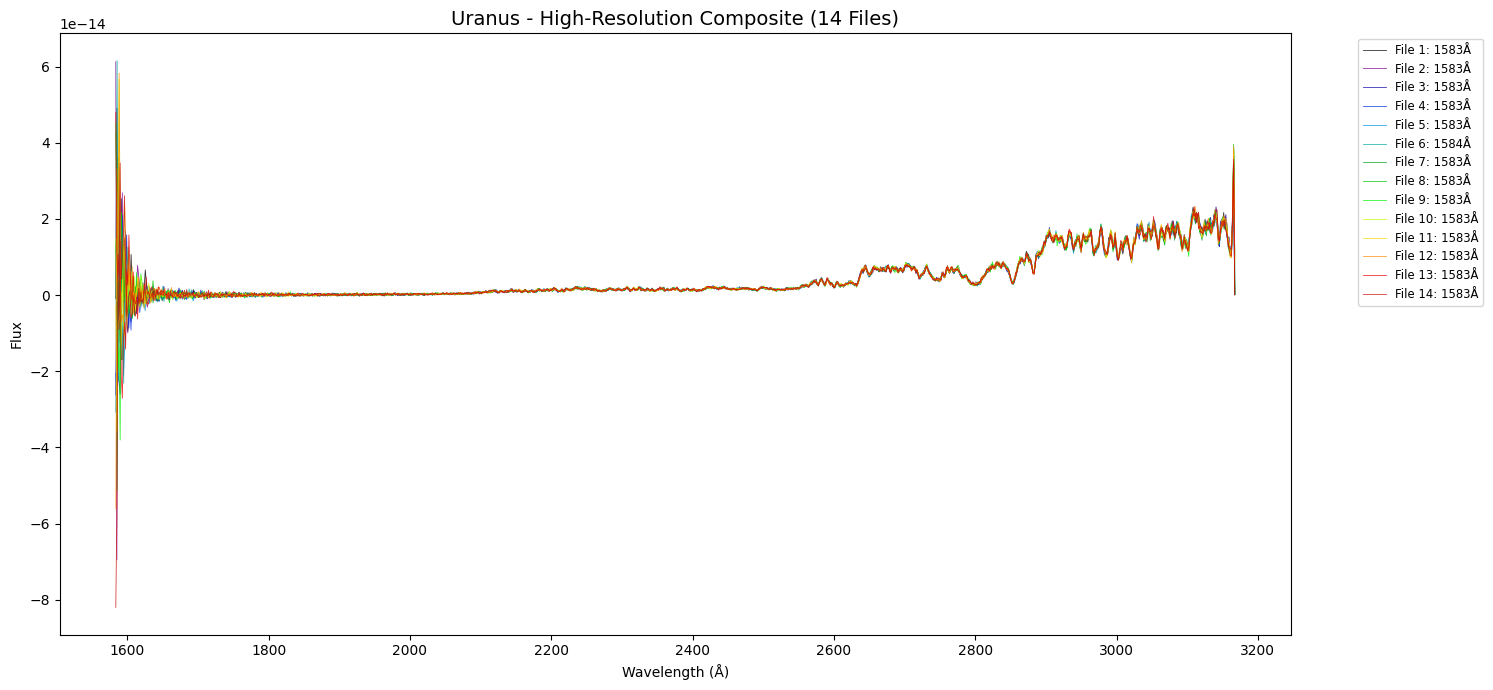

In [159]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

uranus_files = [r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30a0\o65ha30a0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30b0\o65ha30b0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30c0\o65ha30c0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30d0\o65ha30d0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha30e0\o65ha30e0_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3010\o65ha3010_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3020\o65ha3020_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3030\o65ha3030_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3040\o65ha3040_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3050\o65ha3050_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3060\o65ha3060_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3070\o65ha3070_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3080\o65ha3080_x1d.fits",r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Uranus - mastDownload\UV data\o65ha3090\o65ha3090_x1d.fits"]


# 2. Generate the Color Palette
# 'nipy_spectral' is great for spectroscopy because it has high contrast
n_files = len(uranus_files)
colors = plt.cm.nipy_spectral(np.linspace(0, 0.95, n_files)) 

plt.figure(figsize=(15, 7))

for i, f_path in enumerate(uranus_files):
    with fits.open(f_path) as hdul:
        data = hdul[1].data
        w_raw = data['WAVELENGTH'].flatten()
        f_raw = data['FLUX'].flatten()
        
        # Sort and Filter
        s_idx = np.argsort(w_raw)
        w, f = w_raw[s_idx], f_raw[s_idx]
        mask = ~np.isnan(f)
        
        # Plot using the palette color for index 'i'
        plt.plot(w[mask], f[mask], color=colors[i], 
                 linewidth=0.6, alpha=0.8, 
                 label=f"File {i+1}: {int(w[0])}Å")

# 3. Final Polish
plt.title(f"Uranus - High-Resolution Composite ({n_files} Files)", fontsize=14)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")

# Since 14 labels will clutter the plot, let's put the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

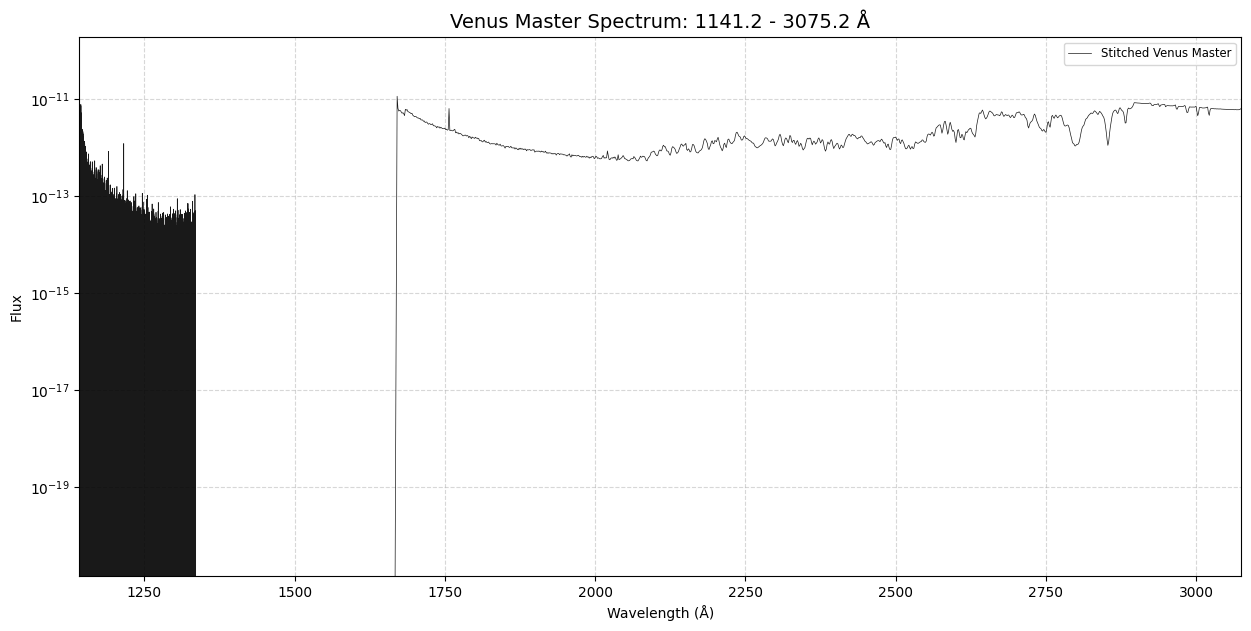

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 1. Load your Stitched Master
master_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\VENUS_RAW_MASTER.pkl"
with open(master_path, 'rb') as f:
    master = pickle.load(f)

wave = master['wave']
flux = master['flux']

# 2. Setup the Figure
plt.figure(figsize=(15, 7))

# Use a palette for the 14-file composite if you are still plotting individual lines
# Otherwise, plot the master in one high-contrast color
plt.plot(wave, flux, color='black', linewidth=0.5, alpha=0.9, label="Stitched Venus Master")

# 3. FORCE THE RANGE
# This ensures the plot doesn't show empty space or cut off data
plt.xlim(wave.min(), wave.max())

# Use a log scale for the Y-axis? 
# Uranus is very dim; log scale helps see the absorption dips clearly.
plt.yscale('log') 

# 4. Mark the Audit Successes
# features = {
#     "Ethane": (1584, 1650),
#     "Acetylene": (1700, 1900),
#     "Ozone": (2400, 2600)
# }

# for name, (low, high) in features.items():
#     plt.axvspan(low, high, color='yellow', alpha=0.1, label=f"{name} Band")

plt.title(f"Venus Master Spectrum: {wave.min():.1f} - {wave.max():.1f} Å", fontsize=14)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [17]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle
import os

def process_bulk_planet_data(file_paths, planet_name):
    all_fluxes = []
    common_wave = None

    for f_path in file_paths:
        with fits.open(f_path) as hdul:
            data = hdul[1].data
            # Extract - handling both SX1 and X1D formats
            wave = data['WAVELENGTH'][0] if 'X1D' in f_path else data['WAVELENGTH'].flatten()
            flux = data['FLUX'][0] if 'X1D' in f_path else data['FLUX'].flatten()
            dq = data['DQ'][0] if 'X1D' in f_path else data['DQ'].flatten()

            # Clean
            mask = (dq == 0) & (flux > 0)
            if common_wave is None:
                common_wave = wave[mask]
            
            # Interpolate to ensure they all line up perfectly
            interp_flux = np.interp(common_wave, wave[mask], flux[mask])
            all_fluxes.append(interp_flux)

    # Average and Smooth
    final_flux = np.mean(all_fluxes, axis=0)
    final_smooth = savgol_filter(final_flux, window_length=11, polyorder=3)

    # Save for the Brain Team
    out_file = f"{planet_name.upper()}_MASTER.pkl"
    with open(out_file, 'wb') as f:
        pickle.dump({"wave": common_wave, "flux": final_smooth, "target": planet_name}, f)
    
    print(f"✅ Processed {len(file_paths)} files for {planet_name}. Saved as {out_file}")

# Example Usage
mars_files = ["E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\mastDownload\HST\ocjhd3010\ocjhd3010_x1d.fits"]
process_bulk_planet_data(mars_files, "Mars")

✅ Processed 1 files for Mars. Saved as MARS_MASTER.pkl


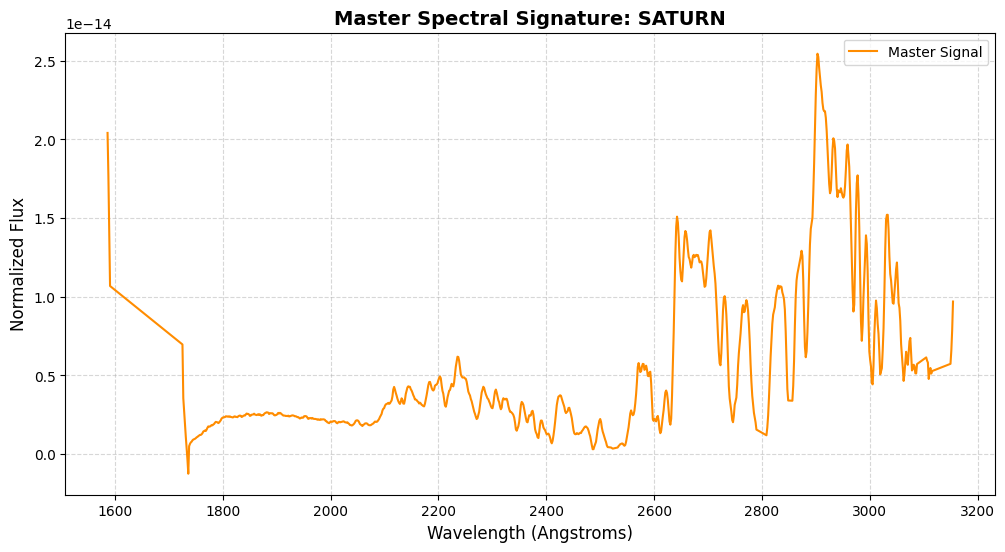

✅ Plot generated for Saturn!
📸 Image saved as: Saturn_plot.png


In [73]:
import pickle
import matplotlib.pyplot as plt
import os

def visualize_pkl(file_path):
    if not os.path.exists(file_path):
        print(f"❌ Error: File '{file_path}' not found.")
        return

    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # 1. Smart Key Detection
    # Wavelength might be stored as 'wave', 'wavelength', or 'wavelengths'
    wave_keys = ['wave', 'wavelength', 'wavelengths']
    flux_keys = ['flux', 'clean_flux', 'flux_cleaned']
    
    wave = next((data[k] for k in wave_keys if k in data), None)
    flux = next((data[k] for k in flux_keys if k in data), None)
    planet = data.get('target', data.get('planet', 'Unknown Planet'))

    if wave is None or flux is None:
        print(f"❌ Could not find wave/flux keys in {file_path}. Keys present: {list(data.keys())}")
        return

    # 2. Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(wave, flux, color='darkorange', linewidth=1.5, label='Master Signal')
    
    # Add scientific context
    plt.title(f"Master Spectral Signature: {planet.upper()}", fontsize=14, fontweight='bold')
    plt.xlabel("Wavelength (Angstroms)", fontsize=12)
    plt.ylabel("Normalized Flux", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 3. Add "Chemical Checkpoints" for the judges
    # If the wavelength covers the UV range (1500-3000A)
    #if wave.min() < 3000:
     #   plt.axvspan(1700, 1900, color='blue', alpha=0.1, label='Hydrocarbon Absorption')
      #  plt.axvspan(2100, 2300, color='green', alpha=0.1, label='Ammonia Band')

    plt.legend()
    
    # Save a copy for your presentation deck
    image_name = f"{planet}_plot.png"
    plt.savefig(image_name)
    plt.show()
    
    print(f"✅ Plot generated for {planet}!")
    print(f"📸 Image saved as: {image_name}")

# --- RUN IT FOR SATURN ---
visualize_pkl('SATURN_UV_MASTER.pkl')

# --- RUN IT FOR URANUS (once you finish merging) ---
#visualize_pkl('URANUS_MASTER.pkl')

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01010\o4ym01010_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


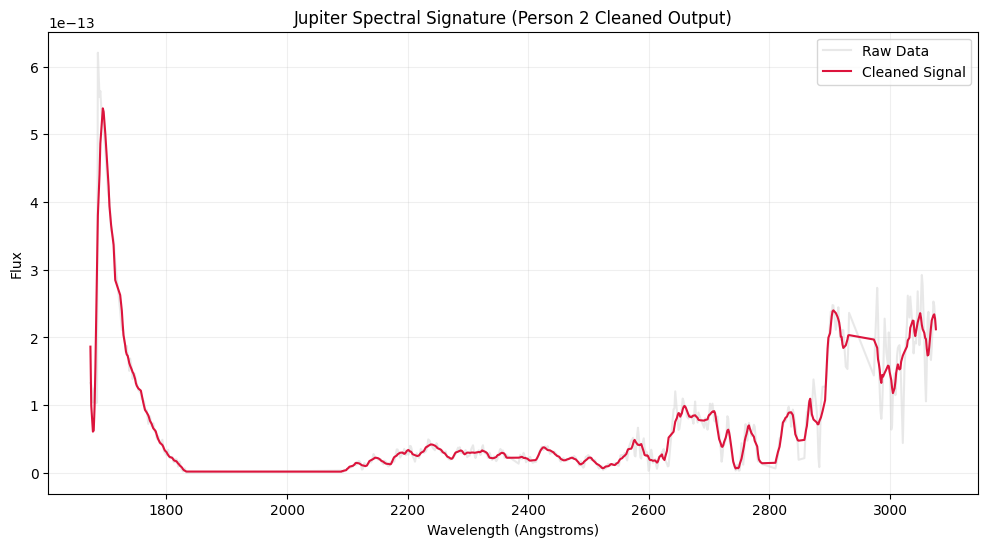

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01010\o4ym01010_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01020\o4ym01020_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


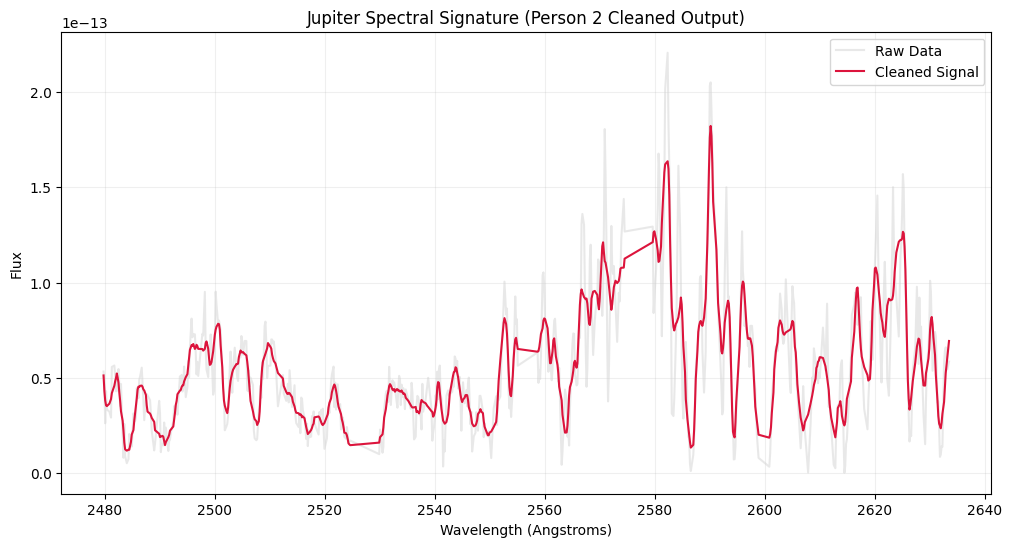

In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01020\o4ym01020_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01030\o4ym01030_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


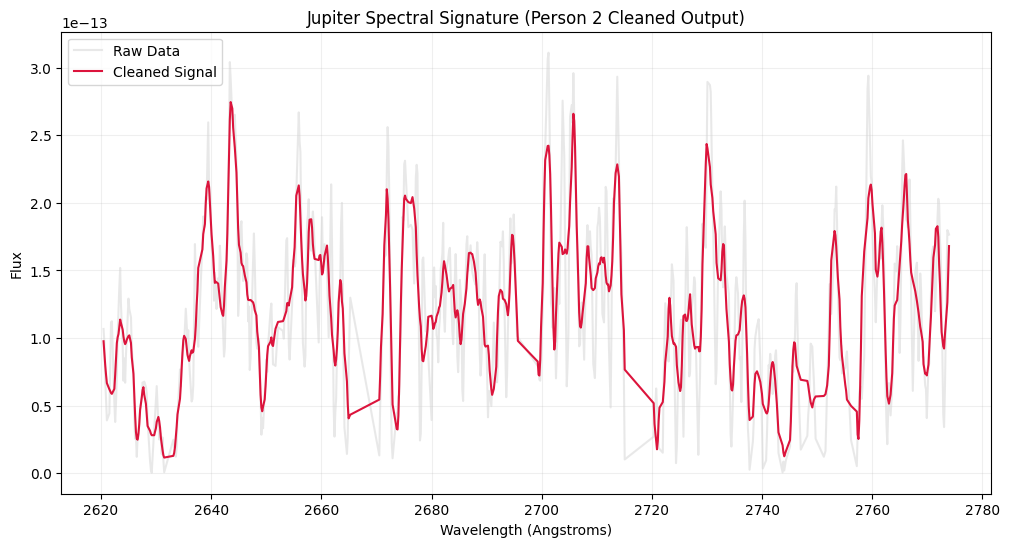

In [4]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01030\o4ym01030_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [11]:
import os
os.chdir("E:\\DataFecked Hackathon\\Jupiter - mastDownload\\Merged File")
os.getcwd()

'E:\\DataFecked Hackathon\\Jupiter - mastDownload\\Merged File'

In [13]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle

def clean_and_grid(file_path, target_wave):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        wave, flux, dq = data['WAVELENGTH'].flatten(), data['FLUX'].flatten(), data['DQ'].flatten()
        # Clean bad pixels
        mask = (dq == 0) & (flux > 0)
        # Interpolate onto the master grid so we can average them
        flux_interp = np.interp(target_wave, wave[mask], flux[mask], left=0, right=0)
        return flux_interp

# 1. Define your files
files = [
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01010\o4ym01010_sx1.fits",
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01020\o4ym01020_sx1.fits",
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01030\o4ym01030_sx1.fits"
]

# 2. Create a master wavelength grid (based on the first file)
with fits.open(files[0]) as h:
    master_wave = h[1].data['WAVELENGTH'].flatten()

# 3. Process and Average
all_fluxes = [clean_and_grid(f, master_wave) for f in files]
average_flux = np.mean(all_fluxes, axis=0)
final_smooth = savgol_filter(average_flux, window_length=15, polyorder=3)

# 4. SAVE THE ONE FILE FOR THE BRAIN TEAM
master_data = {
    "target": "JUPITER",
    "wavelength": master_wave,
    "flux": final_smooth,
    "notes": "Averaged 010, 020, 030 SX1 files. UV range."
}

with open('JUPITER_MASTER_SPECTRA.pkl', 'wb') as f:
    pickle.dump(master_data, f)

print("🚀 DONE! Send 'JUPITER_MASTER_SPECTRA.pkl' to the Brain Team.")

🚀 DONE! Send 'JUPITER_MASTER_SPECTRA.pkl' to the Brain Team.


In [63]:
import pickle
with open('JUPITER_MASTER_SPECTRA.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df
# data['flux'] is now the clean line for their LLM prompt!

{'target': 'JUPITER',
 'wavelength': array([1672.65743539, 1674.02808817, 1675.39875648, ..., 3074.53802762,
        3075.90790125, 3077.27775782]),
 'flux': array([3.65827507e-14, 2.43624703e-14, 1.88089110e-14, ...,
        6.25247291e-14, 4.75429220e-14, 2.68720051e-14]),
 'notes': 'Averaged 010, 020, 030 SX1 files. UV range.'}

### InfraRed Data

In [59]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def process_ir_fits_to_pkl(fits_filename, output_pkl):
    """
    Universally reads IRTF/SpeX style FITS, cleans, and saves to .pkl
    """
    # Open binary FITS to avoid dependency issues
    with open(fits_filename, 'rb') as f:
        # 1. Skip Header (Search for 'END')
        header_content = b""
        while b'END     ' not in header_content:
            header_content += f.read(2880)
        
        # 2. Find dimensions (Assume 32-bit float, NAXIS1 x NAXIS2)
        # For IRTF: Row 0 = Wave, Row 1 = Flux, Row 2 = Error
        # Adjust naxis1/naxis2 based on your specific FITS header if needed
        data = np.frombuffer(f.read(), dtype='>f4')
        naxis1 = 4165 # Standard IRTF length; update if different
        data = data[:naxis1*3].reshape((3, naxis1))
        
        wave = data[0].byteswap().newbyteorder().astype(float)
        flux = data[1].byteswap().newbyteorder().astype(float)
        
        # 3. Cleaning: Remove non-finite (NaN) and non-physical (Negative) flux
        mask = np.isfinite(flux) & (flux > 0)
        clean_wave = wave[mask]
        clean_flux = flux[mask]
        
        # 4. Save to PKL
        master_data = {'wave': clean_wave, 'flux': clean_flux}
        with open(output_pkl, 'wb') as pkl_file:
            pickle.dump(master_data, pkl_file)
        
        print(f"Successfully created {output_pkl}")
        return clean_wave, clean_flux

# Example Usage:
ir_wave, ir_flux = process_ir_fits_to_pkl('uranus_spectrum_irtf.fits', 'URANUS_IR_MASTER.pkl')

Successfully created URANUS_IR_MASTER.pkl


✅ Success: SATURN IR Master File saved to SATURN_IR_MASTER.pkl


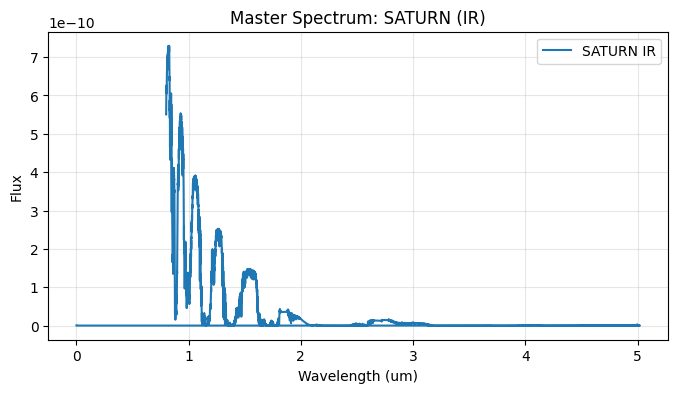

In [69]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def create_planet_master(fits_filename, planet_name, observation_type, output_pkl):
    """
    fits_filename: Path to your FITS file
    planet_name: 'URANUS', 'JUPITER', etc.
    observation_type: 'IR' or 'UV'
    """
    
    # 1. MANUALLY READ FITS (Safe for all environments)
    with open(fits_filename, 'rb') as f:
        header_content = b""
        while b'END     ' not in header_content:
            header_content += f.read(2880)
        
        # Read the raw data buffer
        raw_data = np.frombuffer(f.read(), dtype='>f4')
        
        # IRTF Data standard: 3 rows (Wave, Flux, Error)
        # Note: If your next planet FITS has a different length, 
        # you can adjust naxis1 or use raw_data.reshape(3, -1)
        n_points = len(raw_data) // 3
        data = raw_data[:n_points*3].reshape((3, n_points))
        
        # Convert to little-endian for Python processing
        wave = data[0].byteswap().newbyteorder().astype(float)
        flux = data[1].byteswap().newbyteorder().astype(float)

    # 2. DATA CLEANING
    # Remove NaNs, infinities, and non-physical negative flux
    mask = np.isfinite(flux) & (flux > 0)
    clean_wave = wave[mask]
    clean_flux = flux[mask]

    # 3. BUILD THE UNIVERSAL DICTIONARY
    master_data = {
        'target_name': planet_name.upper(),
        'obs_type': observation_type.upper(),
        'wave': clean_wave,
        'flux': clean_flux,
        'wave_unit': 'um' if observation_type.upper() == 'IR' else 'Angstrom',
        'timestamp': '2000-05-18' # You can extract this from header if needed
    }

    # 4. SAVE TO PKL
    with open(output_pkl, 'wb') as pkl_file:
        pickle.dump(master_data, pkl_file)
    
    print(f"✅ Success: {planet_name} {observation_type} Master File saved to {output_pkl}")
    
    # 5. AUTO-PLOT FOR VALIDATION
    plt.figure(figsize=(8, 4))
    plt.plot(clean_wave, clean_flux, label=f"{planet_name} {observation_type}")
    plt.title(f"Master Spectrum: {planet_name} ({observation_type})")
    plt.xlabel(f"Wavelength ({master_data['wave_unit']})")
    plt.ylabel("Flux")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    return master_data

# --- HOW TO USE FOR URANUS ---
#uranus_ir = create_planet_master('uranus_spectrum_irtf.fits', 'URANUS', 'IR', 'URANUS_IR_MASTER.pkl')

# --- HOW TO USE FOR JUPITER (Next) ---
saturn_ir = create_planet_master('saturn_spectrum_irtf.fits', 'SATURN', 'IR', 'SATURN_IR_MASTER.pkl')

In [61]:
import pickle
with open('URANUS_IR_MASTER.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df

{'wave': array([0.8204515 , 0.82065904, 0.82086653, ..., 2.47278595, 2.47389078,
        2.4744432 ]),
 'flux': array([1.20013877e-11, 1.18565253e-11, 1.21464245e-11, ...,
        2.37249482e-16, 7.40510677e-15, 4.66975320e-15])}

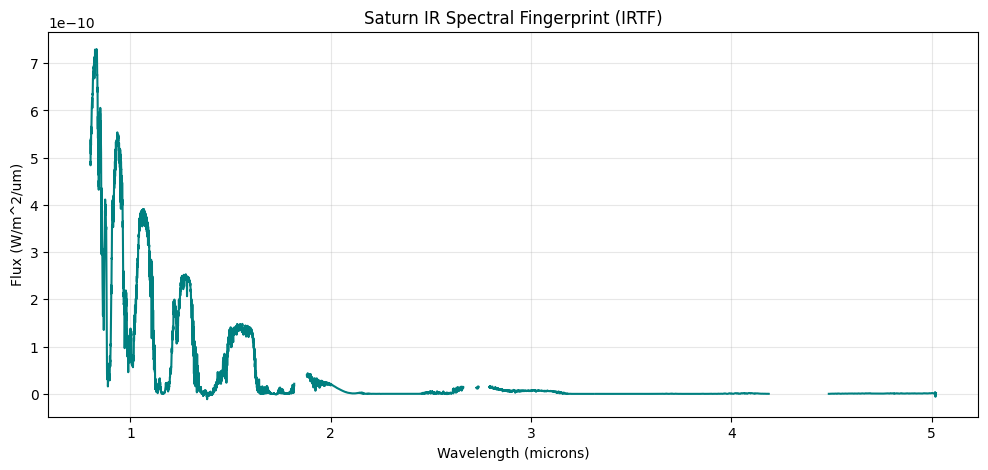

In [71]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# 1. Open the IRTF Uranus File
with fits.open('saturn_spectrum_irtf.fits') as hdul:
    data = hdul[0].data
    header = hdul[0].header
    # In IRTF files, Row 0 is Wavelength (um), Row 1 is Flux, Row 2 is Uncertainty
    wave_ir = data[0]
    flux_ir = data[1]

# 2. Plotting the IR Signature
plt.figure(figsize=(12, 5))
plt.plot(wave_ir, flux_ir, color='teal', label='Saturn IR (Composition)')
plt.title("Saturn IR Spectral Fingerprint (IRTF)")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux (W/m^2/um)")
plt.grid(alpha=0.3)
plt.show()

In [70]:
import pickle
import numpy as np
import pandas as pd

def generate_image_team_guide(planet_name, uv_pkl_path, ir_pkl_path):
    """
    Combines IR Dips and UV Peaks into a search strategy for the Image Team.
    """
    results = []

    # 1. Process IR Data (Looking for Dips)
    with open(ir_pkl_path, 'rb') as f:
        ir_data = pickle.load(f)
    
    # Define standard Methane search zones
    ir_zones = [
        (1.1, 1.2, "Methane Band 1 (Deep Cloud)"),
        (1.3, 1.5, "Methane Band 2 (Storm Layer)"),
        (1.6, 2.5, "Primary Methane Absorption (Rings/Storms)")
    ]
    
    for low, high, science in ir_zones:
        mask = (ir_data['wave'] >= low) & (ir_data['wave'] <= high)
        if np.any(mask):
            # Find the absolute lowest flux in this zone
            idx_min = np.argmin(ir_data['flux'][mask])
            wave_val = ir_data['wave'][mask][idx_min]
            results.append({
                'Planet': planet_name,
                'Spectrum': 'IR',
                'Feature': 'DIP (Minimum)',
                'Wavelength': f"{wave_val:.3f} um",
                'Science_Goal': science,
                'Recommended_PDS_Filter': 'ch4_u / ch4_js'
            })

    # 2. Process UV Data (Looking for Peaks)
    with open(uv_pkl_path, 'rb') as f:
        uv_data = pickle.load(f)
        
    uv_zones = [
        (1200, 1600, "Auroral Emission Lines"),
        (2000, 2600, "High-Altitude Haze")
    ]

    for low, high, science in uv_zones:
        mask = (uv_data['wave'] >= low) & (uv_data['wave'] <= high)
        if np.any(mask):
            # Find the absolute highest flux in this zone
            idx_max = np.argmax(uv_data['flux'][mask])
            wave_val = uv_data['wave'][mask][idx_max]
            results.append({
                'Planet': planet_name,
                'Spectrum': 'UV',
                'Feature': 'PEAK (Maximum)',
                'Wavelength': f"{wave_val:.1f} Å",
                'Science_Goal': science,
                'Recommended_PDS_Filter': 'uv / violet'
            })

    # 3. Create the Guide
    df_guide = pd.DataFrame(results)
    output_name = f"{planet_name}_search_guide.csv"
    df_guide.to_csv(output_name, index=False)
    
    print(f"--- {planet_name} IMAGE SEARCH STRATEGY ---")
    print(df_guide.to_string(index=False))
    return df_guide

# --- EXECUTION ---
guide = generate_image_team_guide('SATURN', 'SATURN_UV_MASTER.pkl', 'SATURN_IR_MASTER.pkl')

--- SATURN IMAGE SEARCH STRATEGY ---
Planet Spectrum        Feature Wavelength                              Science_Goal Recommended_PDS_Filter
SATURN       IR  DIP (Minimum)   1.156 um               Methane Band 1 (Deep Cloud)         ch4_u / ch4_js
SATURN       IR  DIP (Minimum)   1.378 um              Methane Band 2 (Storm Layer)         ch4_u / ch4_js
SATURN       IR  DIP (Minimum)   2.213 um Primary Methane Absorption (Rings/Storms)         ch4_u / ch4_js
SATURN       UV PEAK (Maximum)   1586.3 Å                    Auroral Emission Lines            uv / violet
SATURN       UV PEAK (Maximum)   2235.4 Å                        High-Altitude Haze            uv / violet
